In [6]:
import os
import random
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [7]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [8]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../datasets/dl2020'
annotation_csv = '../datasets/dl2020/annotation_newfeat.csv'

In [9]:
anno = pd.read_csv(annotation_csv)

In [11]:
len(anno.columns)

27

In [19]:
example = anno[anno['category_id'] == 8]

In [20]:
example.head()

,Unnamed: 0,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,...,front,front_right,back_left,back,back_right,distance,center_x,center_y,box_width,box_height
24453,24453,107,14,object_action_walking,animal,14.013089,13.999948,13.427134,13.413992,10.383758,...,False,False,False,False,False,17.144658,13.713541,10.289709,0.599097,0.256925
24457,24457,107,15,object_action_walking,animal,13.068930,13.055947,12.482934,12.469951,10.428298,...,False,False,False,False,False,16.427163,12.769441,10.334073,0.598978,0.256544
24461,24461,107,16,object_action_walking,animal,12.214721,12.202064,11.628682,11.616025,10.443321,...,False,False,False,False,False,15.781966,11.915373,10.348640,0.598696,0.255702
24474,24474,107,18,object_action_walking,animal,10.618526,10.606740,10.032358,10.020571,10.529322,...,False,False,False,False,False,14.674831,10.319549,10.433483,0.597955,0.253450
24476,24476,107,19,object_action_walking,animal,9.932528,9.921125,9.346304,9.334901,10.582343,...,False,False,False,False,False,14.239543,9.633714,10.485997,0.597627,0.252497


In [22]:
# 'other_vehicle': 0,
# 'bicycle': 1,
# 'car': 2,
# 'pedestrian': 3,
# 'truck': 4,
# 'bus': 5,
# 'motorcycle': 6,
# 'emergency_vehicle': 7,
# 'animal': 8

In [23]:
labeled_scene_index = np.arange(106, 134)

transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [24]:
sample_cat, sample, target, road_image, extra = iter(trainloader).next()

In [25]:
print(torch.stack(sample_cat).shape)

torch.Size([2, 3, 1536, 306])


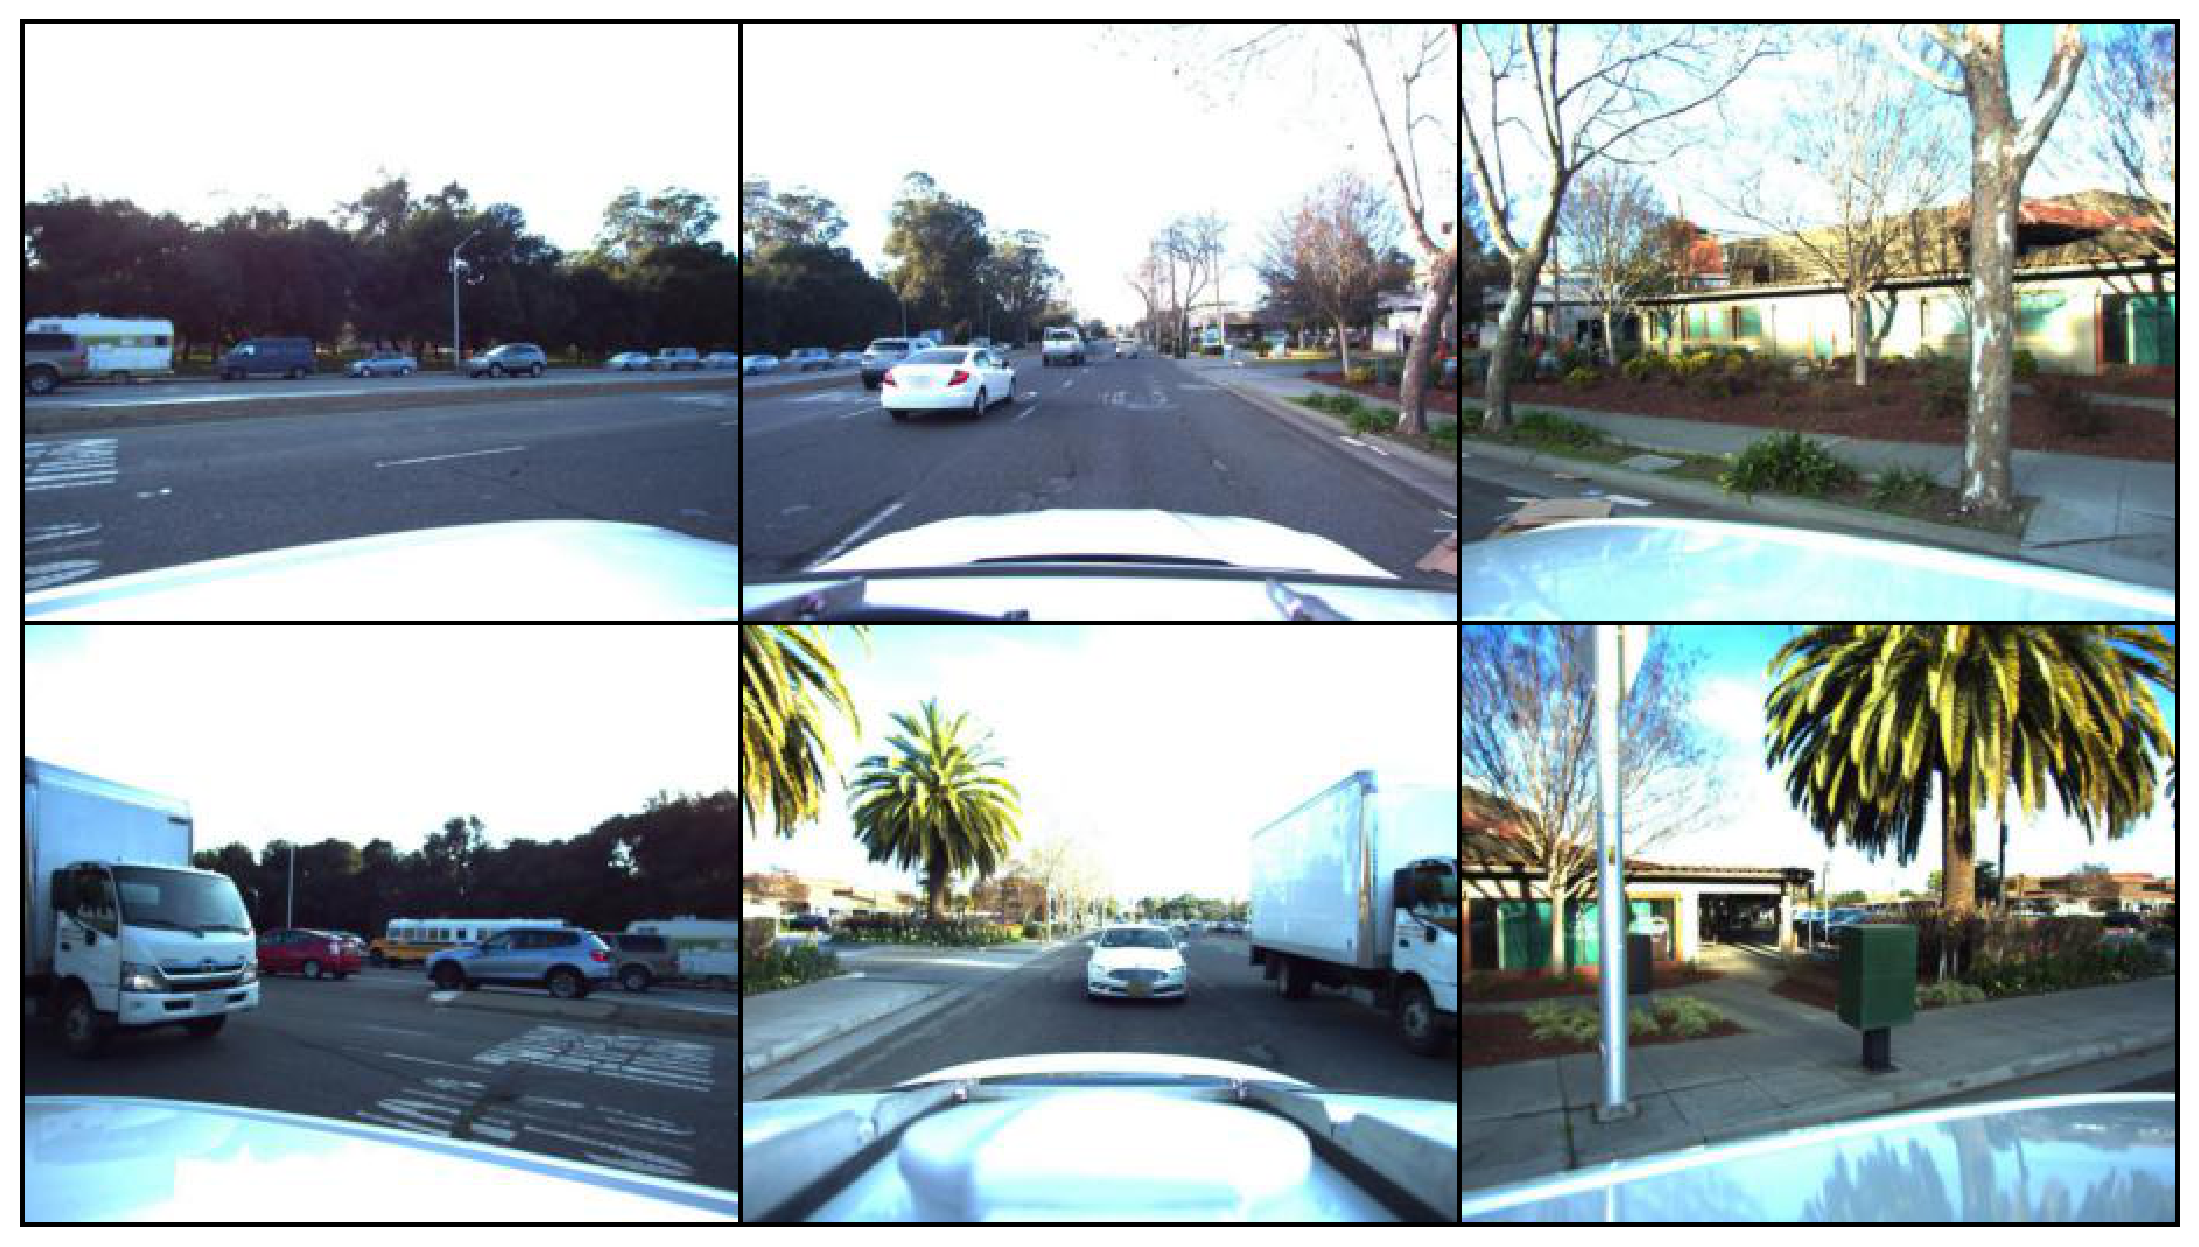

In [26]:
plt.figure(figsize=(20,8))
plt.imshow(torchvision.utils.make_grid(torch.stack(sample)[0], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

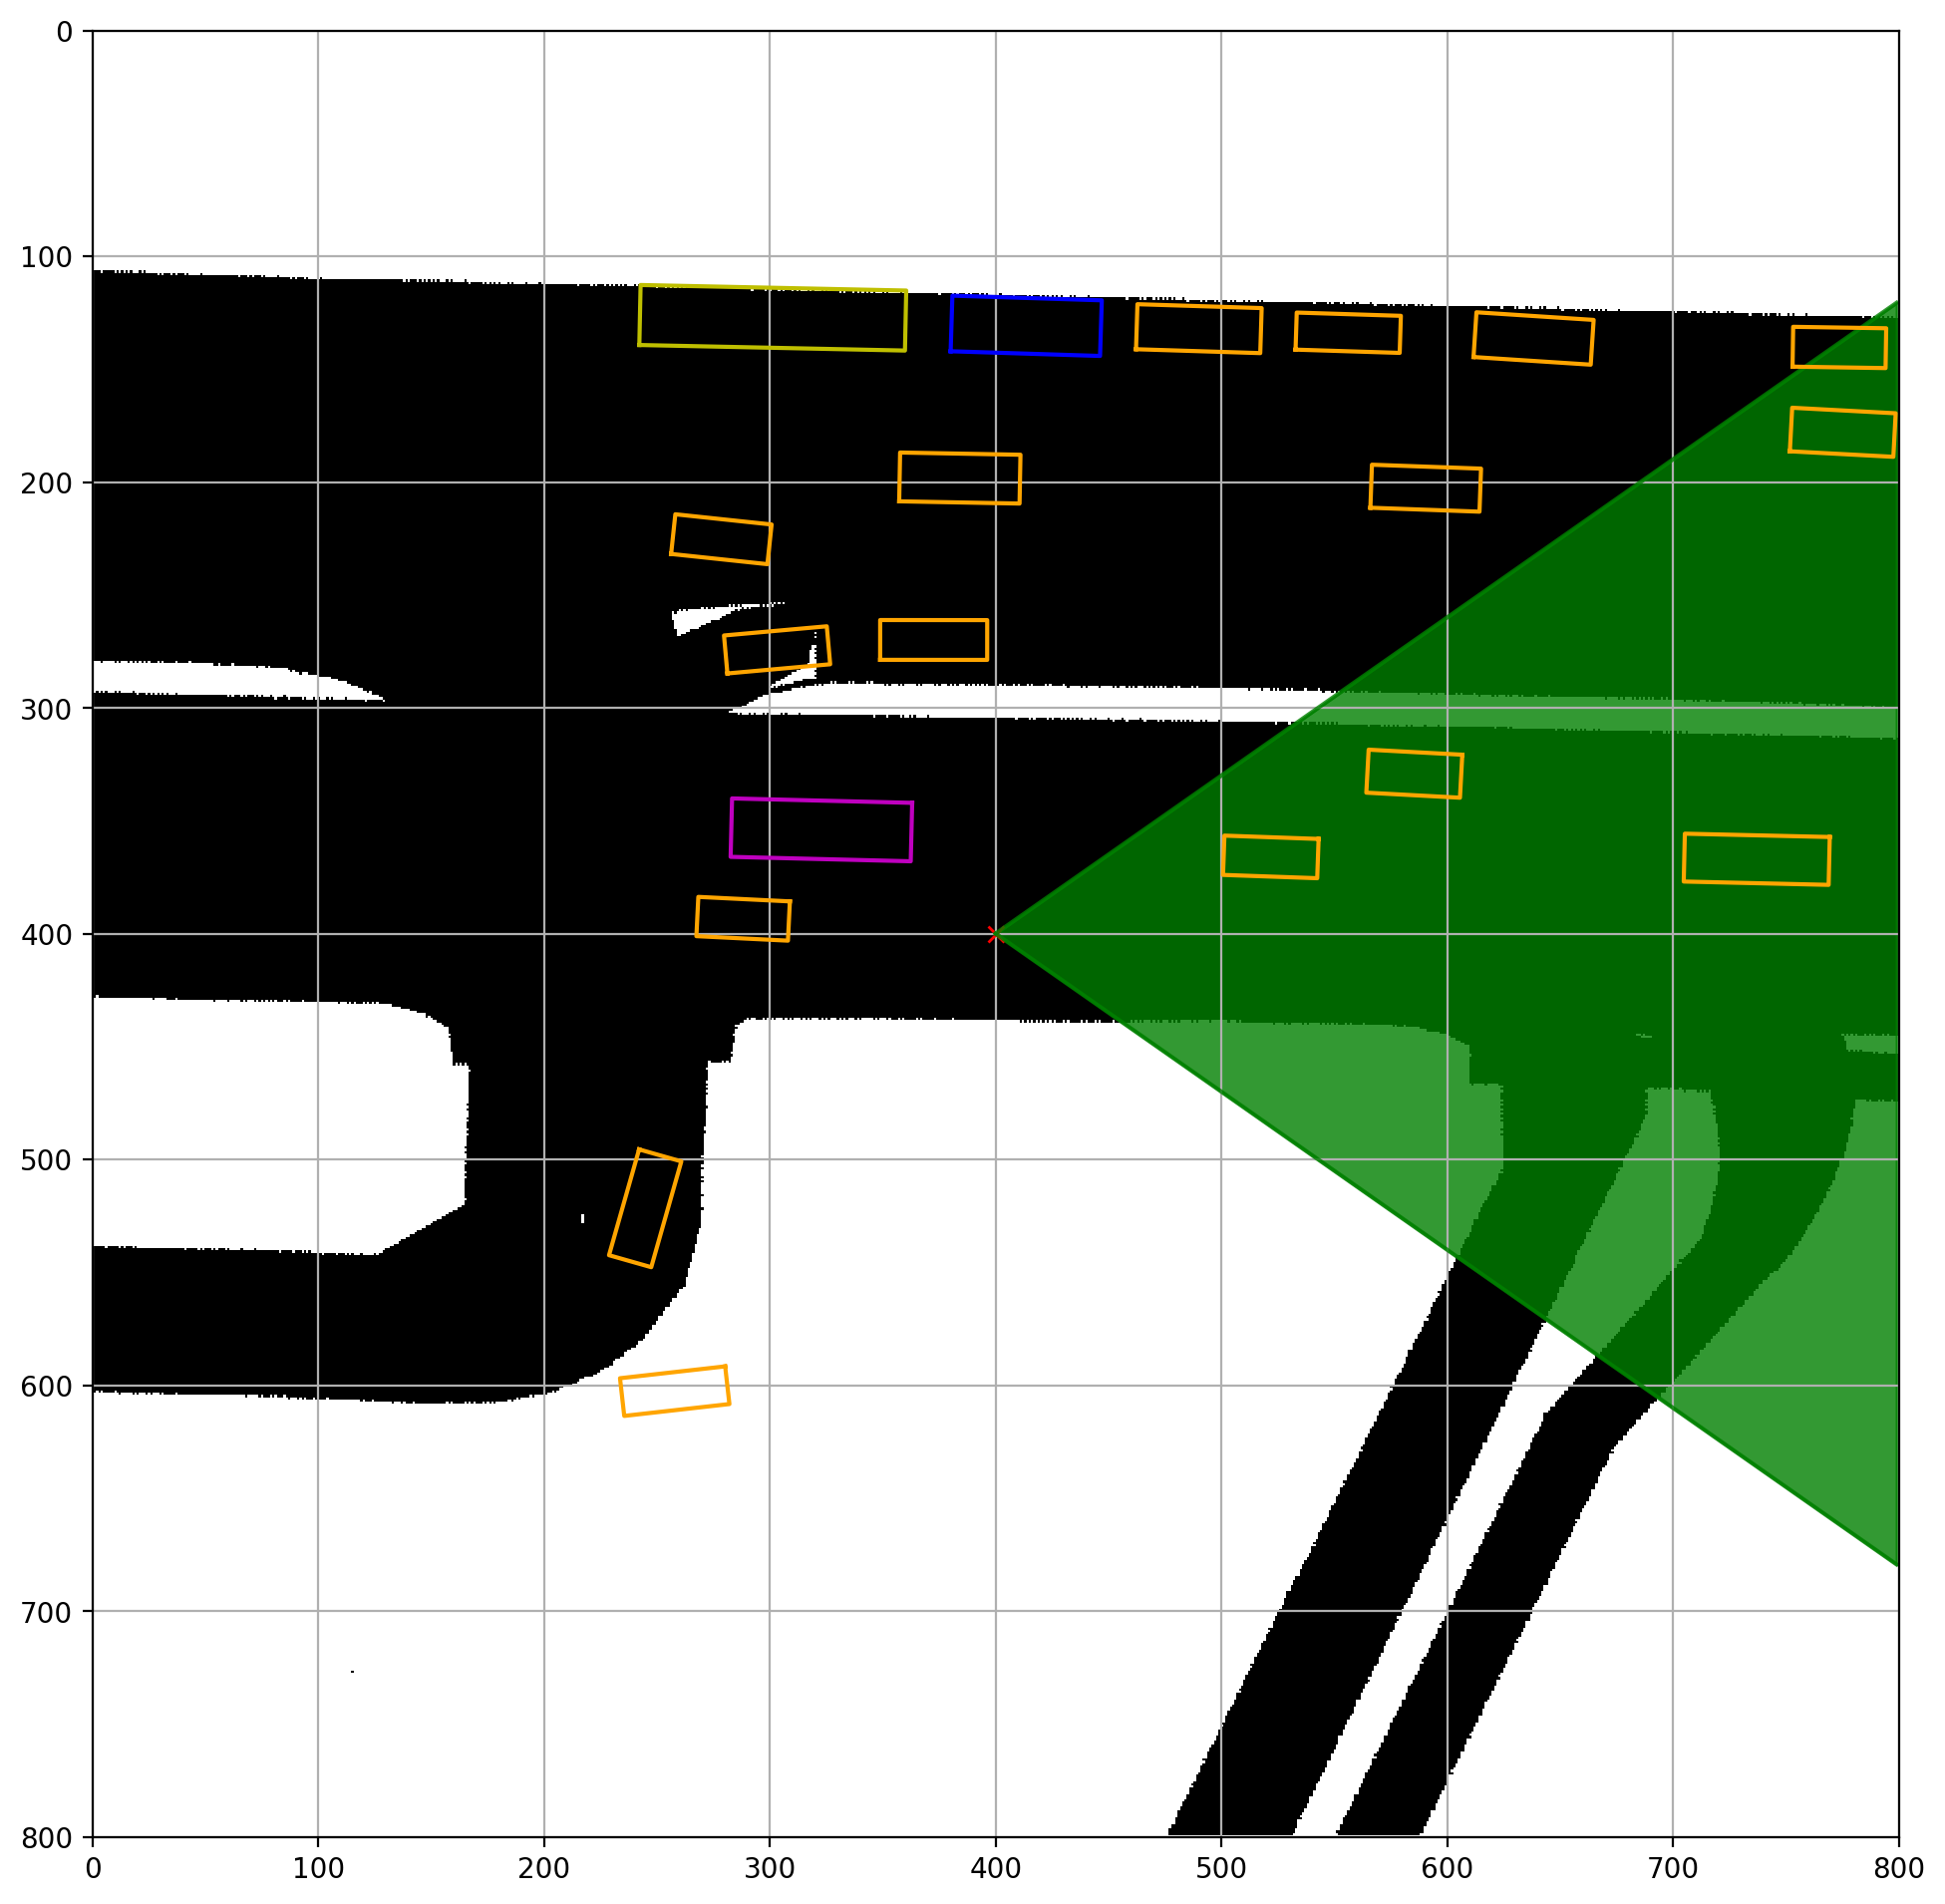

In [27]:
# The center of image is 400 * 400

fig, ax = plt.subplots(figsize=(12,12))



color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']



ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

x = np.arange(400, 800)
y1 = 400 - math.tan(math.pi*(35/180))*(x-400)
y2 = 400 + math.tan(math.pi*(35/180))*(x-400)
ax.plot(x, y1, color = 'green', alpha = 0.8)
ax.plot(x, y2, color = 'green', alpha = 0.8)
ax.fill_between(x, y1, y2, color = 'green', alpha = 0.8)
ax.set_xlim([0, 800])
ax.set_ylim([800, 0])


for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])   
    
ax.grid()

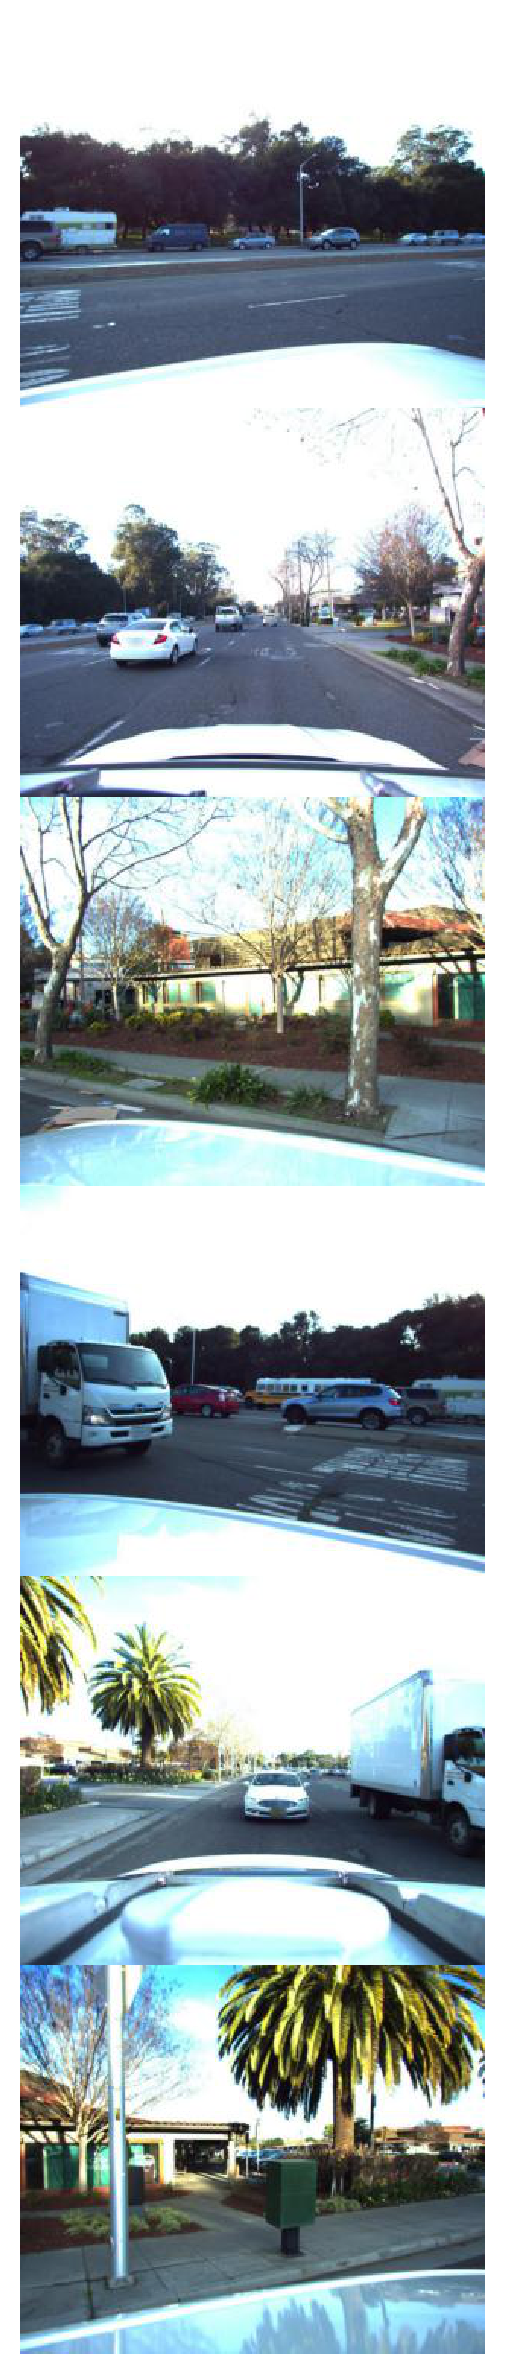

In [28]:
plt.figure(figsize=(3,18))
plt.imshow(torchvision.utils.make_grid(torch.stack(sample_cat)[0], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

# Define Sample

In [ ]:
labeled_scene_index = np.arange(107, 134)

transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=15, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [ ]:
sample_cat,sample, target, road_image, extra = iter(trainloader).next()

In [ ]:
# road_image[0]

# Redo Plot draw_box

In [ ]:
def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.T[0], point_squence.T[1], color=color)

# Range Plot

In [ ]:
bounds = [(95, 25), (35, -35), (-25, -95), (155, 85), (-145, 145), (-85, -155)]
bounds_coef = [(math.tan(math.pi*(y1/180)), math.tan(math.pi*(y2/180))) for (y1, y2) in bounds]
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
camera_name = ['front_left', 'front', 'front_right', 'back_left', 'back', 'back_right']

In [ ]:
def plot_range(sample_index):
    
    fig, ax = plt.subplots(nrows=6, ncols=2,figsize=(15,45))

    for i in range(6):
        ax[i, 0].imshow(torchvision.utils.make_grid(torch.stack(sample)[sample_index][i], nrow=3).numpy().transpose(1, 2, 0))
        ax[i, 0].axis('off')
            
        ax[i, 1].imshow(road_image[sample_index], cmap='binary', extent=[-40,40,-40,40])
        
        if abs(bounds[i][0]) > 90: 
            x1 = np.arange(0, -40, -1)
        else:
            x1 = np.arange(0, 40)
            
        if abs(bounds[i][1]) > 90: 
            x2 = np.arange(0, -40, -1)
        else:
            x2 = np.arange(0, 40)

        ax[i, 1].scatter(0, 0, c = 'r', marker = 'x')

        y1 = bounds_coef[i][0] * x1
        y2 = bounds_coef[i][1] * x2
        
        
        ax[i, 1].plot(x1, y1, color = 'green', alpha = 0.5)
        ax[i, 1].plot(x2, y2, color = 'green', alpha = 0.5)
        
        if x1[1] == x2[1]:
            ax[i, 1].fill_between(x1, y1, y2, color = 'green', alpha = 0.5)
        else:
            ax[i, 1].fill_between(x1, y1, np.sign(y1[1])*40, color = 'green', alpha = 0.5)
            ax[i, 1].fill_between(x2, y2, np.sign(y2[1])*40, color = 'green', alpha = 0.5)
            
        
        ax[i, 1].set_xlim([-40, 40])
        ax[i, 1].set_ylim([-40, 40])
        ax[i, 1].grid()
        
        for j, bb in enumerate(target[sample_index]['bounding_box']):
            draw_box(ax[i, 1], bb, color=color_list[target[sample_index]['category'][j]])   
             
        

In [ ]:
plot_range(14)

# Feature - Which Camera

In [ ]:
anno[anno['scene'] == 106][anno['sample'] == 0]

In [ ]:
bounds_quat = [[3,1], [1,4], [4,3], [2,1], [3,2], [4,3]]

In [ ]:
def check_cam_index(index, camera_index):
    points = [(anno.iloc[index, 4+i], anno.iloc[index, 8+i]) for i in range(4)]
#     print(np.sign(points))
    for x, y in points:
        
        if np.sign(x) == 1 and np.sign(y) == 1:
            quat = 1
        elif np.sign(x) == 1 and np.sign(y) == -1:
            quat = 4
        elif np.sign(x) == -1 and np.sign(y) == 1:
            quat = 2
        else:
            quat = 3
            
        if quat not in bounds_quat[camera_index]:
            continue
            
        angle = math.atan(y/x)/math.pi*180
        
        if quat in [1,2] and angle < 0:
            angle += 180
        elif quat in [3,4] and angle > 0:
            angle -= 180
        
        if camera_index == 4:
            if abs(angle) > 145:
                return True
        else:
            if angle >= min(bounds[camera_index]) and angle <= max(bounds[camera_index]):
                return True
            
    
    return False

In [ ]:
def check_cam_row(row, camera_index):
    points = [(row.iloc[4+i], row.iloc[8+i]) for i in range(4)]
#     print(np.sign(points))
    for x, y in points:
        
        if np.sign(x) == 1 and np.sign(y) == 1:
            quat = 1
        elif np.sign(x) == 1 and np.sign(y) == -1:
            quat = 4
        elif np.sign(x) == -1 and np.sign(y) == 1:
            quat = 2
        else:
            quat = 3
            
        if quat not in bounds_quat[camera_index]:
            continue
            
        angle = math.atan(y/x)/math.pi*180
        
        if quat in [1,2] and angle < 0:
            angle += 180
        elif quat in [3,4] and angle > 0:
            angle -= 180
        
        if camera_index == 4:
            if abs(angle) > 145:
                return True
        else:
            if angle >= min(bounds[camera_index]) and angle <= max(bounds[camera_index]):
                return True
            
    
    return False

In [ ]:
for index, name in enumerate(camera_name):
    anno[name] = anno.apply(lambda x: check_cam_row(x, index), axis = 1)

In [ ]:
anno.head()

# Feature - Distance

In [ ]:
def get_distance(row):
    x = np.mean(row.iloc[4:8])
    y = np.mean(row.iloc[8:12])
    return np.sqrt(x**2 + y**2)

In [ ]:
anno['distance'] = anno.apply(lambda x: get_distance(x), axis = 1)

In [ ]:
anno.head()

In [ ]:
idx = [i for i in range(road_image[0].size(0) -1, -1, -1)]
idx = torch.LongTensor(idx)
inverted_roadimage = road_image[0].index_select(0, idx)

In [ ]:
road_image[0]

# Look at COCO annotation

In [ ]:
import json

In [ ]:
# Reading the json as a dict
with open('instances_val2017.json') as json_data:
    data = json.load(json_data)

# using the from_dict load function. Note that the 'orient' parameter 
#is not using the default value (or it will give the same error than you had)
# We transpose the resulting df and set index column as its index to get this result
# pd.DataFrame.from_dict(data, orient='index').T.set_index('index')   

In [ ]:
# data

# Try Concat Images

In [ ]:
a = torch.rand(6, 3, 10, 20)
# b = torch.rand(6, 3, 10, 20)

In [ ]:
a.shape

In [ ]:
c = torch.cat((a, b), 1)
c.shape

In [ ]:
labeled_scene_index = np.arange(106,108)

transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)


In [ ]:
sample_cat, sample, target, road_image, extra = iter(trainloader).next()

In [ ]:
print(torch.stack(sample_cat).shape)

# Try tqdm

In [ ]:
from tqdm.autonotebook import tqdm

In [ ]:
progress_bar = tqdm(trainloader)
for iter, data in enumerate(progress_bar):
    print(iter)
    sample_cat, sample, target, road_image, extra = data
    print(torch.stack(sample_cat).shape)
    break

In [ ]:
trainloader

# Feature - weight/height/centerx/centery style annotation

In [ ]:
def get_whxy(row):
    x = np.mean(row.iloc[4:8])
    y = np.mean(row.iloc[8:12])
    w = abs(max(row.iloc[4:8]) - min(row.iloc[4:8]))
    h = abs(max(row.iloc[8:12]) - min(row.iloc[8:12]))
    return np.array([x, y, w, h])

In [ ]:
anno['center_x'], anno['center_y'], anno['box_width'], anno['box_height'] = np.array(anno.apply(lambda x: get_whxy(x), axis = 1).tolist()).T

In [ ]:
anno.head()

# Try CV2 Read Image

In [ ]:
import cv2

In [ ]:
img = cv2.imread('/Users/mjin/Desktop/1008/Project/DeepLearning2020/datasets/dl2020/scene_106/sample_0/CAM_BACK_LEFT.jpeg')

In [ ]:
type(img)

In [ ]:
image_names = [
    'CAM_FRONT_LEFT.jpeg',
    'CAM_FRONT.jpeg',
    'CAM_FRONT_RIGHT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    ]

In [ ]:
images = []
image_cat = []
for image_name in image_names:
    image_path = '/Users/mjin/Desktop/1008/Project/DeepLearning2020/datasets/dl2020/scene_106/sample_0/CAM_BACK_LEFT.jpeg'
    image = cv2.imread(image_path)
    if len(image_cat) < 1:
        image_cat = image
    else:
        image_cat = np.concatenate((image_cat, image), axis=0)
    images.append(image)

In [ ]:
image_cat.shape

# Try new data loader

In [4]:
from data_helper import LabeledDataset_coco, Resizer, Normalizer, Augmenter, collater
from torchvision import transforms

In [5]:
labeled_scene_index = np.arange(107, 134)

transform = transforms.Compose([Normalizer(mean=params.mean, std=params.std),\
                                    Augmenter(),\
                                    Resizer(input_sizes[opt.compound_coef])])

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=15, shuffle=False, num_workers=0, collate_fn=collate_fn)

NameError: name 'params' is not defined

In [18]:
for i, j in anno.iterrows():
    print(j['center_x'])
    break

-11.991556941178976
